# **Digital Image Processing - Midterm essay**

This notebook demonstrates automatic detection of:
- Traffic sign in all frames of the input video (Task 1)

### **1. Import library, imshow function and Frame class for all process**

#### 1.1. Library and environment

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os

#### 1.2. Imshow function

Use matplotlib and cv2 for show RGB frame

In [10]:
def imshow(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')

#### 1.3. Frame Processor Class

All technique for processing frame will implement in CLASS

In [23]:
class FrameProcessor:
    def __init__(self):
        self.lower_red1 = np.array([0, 0, 0])
        self.upper_red1 = np.array([5, 255, 255])
        self.lower_red2 = np.array([113, 0, 50])
        self.upper_red2 = np.array([179, 200, 210])
        self.lower_blue = np.array([100, 100, 90])
        self.upper_blue = np.array([130, 255, 255])
        self.error_lower_red = np.array([100, 0, 30])
        self.error_upper_red = np.array([113, 250, 150])

    def preprocess(self, img, clip, tile, k_size, sigma, gam=True):
        def contrast_limited_adaptive_histogram_equalization(channel, clip, tile):
            return cv.createCLAHE(clipLimit=clip, tileGridSize=tile).apply(channel)

        def blurr(img, k_size, sigma):
            return cv.GaussianBlur(img, k_size, sigma)
        
        def adjust_gamma(img, gamma):
            invGamma = 1 / gamma
            table = np.array([((i / 255) ** invGamma) * 255 for i in np.arange(256)]).astype("uint8")
            return cv.LUT(img, table)
        
        img_gm = adjust_gamma(img, gamma=2) if gam else img
        blurr = cv.GaussianBlur(img_gm, (5, 5), 0)
        hsv = cv.cvtColor(blurr, cv.COLOR_BGR2HSV)
        h, s, v = cv.split(hsv)
        v_clahe = contrast_limited_adaptive_histogram_equalization(v, clip, tile)
        hsv = cv.merge([h, s, v_clahe])
        return hsv

    def merge_masks(self, hsv_img, morphology=True):
        MORPH_KERNEL = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
        DILATE_KERNEL = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))

        def clean_mask(mask, kernel=MORPH_KERNEL, iterations=1):
            m = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=iterations)
            m = cv.morphologyEx(m, cv.MORPH_CLOSE, kernel, iterations=iterations)
            return m
        
        mask_red = cv.bitwise_or(
            cv.inRange(hsv_img, self.lower_red1, self.upper_red1),
            cv.inRange(hsv_img, self.lower_red2, self.upper_red2)
        )
        mask_error_red = cv.inRange(hsv_img, self.error_lower_red, self.error_upper_red)
        mask_blue = cv.inRange(hsv_img, self.lower_blue, self.upper_blue)
        if morphology:
            mask_red = clean_mask(mask_red, MORPH_KERNEL, iterations=1)
            mask_blue = clean_mask(mask_blue, MORPH_KERNEL, iterations=1)
            mask_red = cv.dilate(mask_red, DILATE_KERNEL, iterations=1)
            mask_blue = cv.dilate(mask_blue, DILATE_KERNEL, iterations=1)
        return mask_red, mask_blue

    def contour_process(self, img, mask_red, mask_blue, epsilon, min_area):
        masks = [mask_red, mask_blue]
        output_contour = []
        for mask in masks:
            contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            output_contour.append(contours)
            
            # Retrival part
            for cnt in contours:
                area = cv.contourArea(cnt)
                if area < min_area:
                    continue
                
                perimeter = cv.arcLength(cnt, True)
                approximate = cv.approxPolyDP(cnt, epsilon * perimeter, True)
                if len(approximate) == 3:
                    pts = [approximate[i][0] for i in range(3)]
                    d1 = np.linalg.norm(pts[0] - pts[1])
                    d2 = np.linalg.norm(pts[1] - pts[2])
                    d3 = np.linalg.norm(pts[2] - pts[0])

                    average = (d1 + d2 + d3) / 3
                    deviation = 0.2 * average

                    if abs(d1 - average) < deviation and abs(d2 - average) < deviation and abs(d3 - average) < deviation:
                        x, y, w, h = cv.boundingRect(approximate)
                        cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                (x_c, y_c), radius = cv.minEnclosingCircle(cnt)
                radius = float(radius)
                circle_area = np.pi * (radius ** 2) if radius > 0 else 1.0
                circularity = area / circle_area
                if circularity > 0.67:
                    center = (int(x_c), int(y_c))
                    r = int(radius)
                    x0, y0 = max(0, center[0] - r), max(0, center[1] - r)
                    x1, y1 = center[0] + r, center[1] + r
                    cv.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)
                    continue
                
        return img

    def pipeline_full_process(self, img, clip=3.0, tile=(8, 8), k_size=5, sigma=0, gamma=True, epsilon=0.03, min_area=600):
        preprocessed = self.preprocess(img, clip, tile, k_size, sigma, gamma)
        mask_red, mask_blue = self.merge_masks(preprocessed)
        result = self.contour_process(img, mask_red, mask_blue, epsilon, min_area)
        return result

### **2. Video loading and overview first frame**

#### 2.1. Video loading

In [12]:
INPUT_VIDEO = "task1.mp4"
OUTPUT_VIDEO = "task1_output.mp4"

cap = cv.VideoCapture(INPUT_VIDEO)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {INPUT_VIDEO}")

frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv.CAP_PROP_FPS) 
print(f"[INFO] fps={fps}, size=({frame_width},{frame_height})")

[INFO] fps=29.97002997002997, size=(1920,1080)


#### 2.2. Overview first frame, what problem will solve for this task

The challenges posed by variable lighting, shadows, glare, and sensor noise, which are appear in real-world driving scenarios.

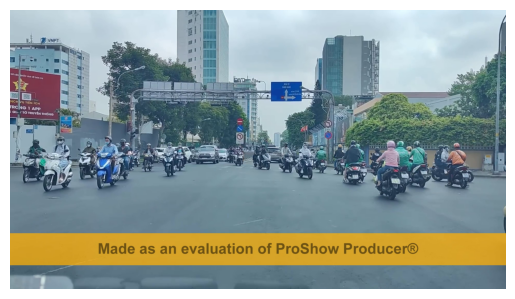

In [13]:
ret, frame = cap.read()

imshow(frame)

### **3. Preprocessing**

#### 3.1 Standard Preprocessing

The image is first smoothed using Gaussian blur to reduce noise and small variations. It is then converted to HSV color space, allowing independent handling of brightness and color. Finally, CLAHE is applied to the V channel to enhance local contrast and reveal more details under uneven lighting.

(<Axes: title={'center': 'Preprocessed Standard Frame'}>,
 None,
 Text(0.5, 1.0, 'Preprocessed Standard Frame'))

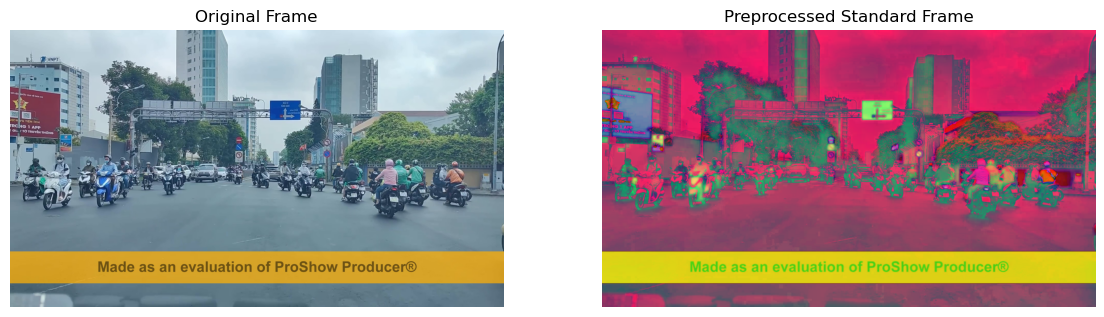

In [29]:
frame_processor = FrameProcessor()

preprocessed_frame = frame_processor.preprocess(frame, 3.0, (8, 8), 5, 0)  
pre_without_gamma = frame_processor.preprocess(frame, 3.0, (8, 8), 5, 0, gam=False)

plt.figure(figsize=(14, 9))
plt.subplot(121), imshow(frame), plt.title("Original Frame")
plt.subplot(122), imshow(pre_without_gamma), plt.title("Preprocessed Standard Frame")

#### 3.2. Enhanced Preprocessing with Gamma Correction

Before blurring, gamma correction adjusts the image brightness to balance dark and bright areas. This helps normalize illumination, making subsequent color segmentation and detection more robust in varying lighting conditions.

(<Axes: title={'center': 'Preprocessed Enhanced Frame'}>,
 None,
 Text(0.5, 1.0, 'Preprocessed Enhanced Frame'))

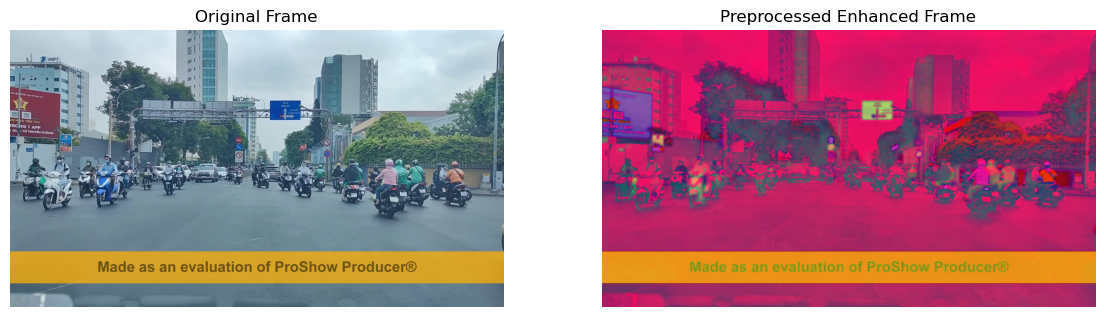

In [28]:
plt.figure(figsize=(14, 9))
plt.subplot(121), imshow(frame), plt.title("Original Frame")
plt.subplot(122), imshow(preprocessed_frame), plt.title("Preprocessed Enhanced Frame")

### **4. Extraction marks**

#### 4.1. Standard Mask Extraction

Extract the red and blue regions based on predefined HSV color thresholds.
This step performs color segmentation under normal conditions without any morphological enhancement. As a result, the masks successfully highlight the color areas of traffic signs.

(<Axes: title={'center': 'Blue Mask raw processing'}>,
 None,
 Text(0.5, 1.0, 'Blue Mask raw processing'))

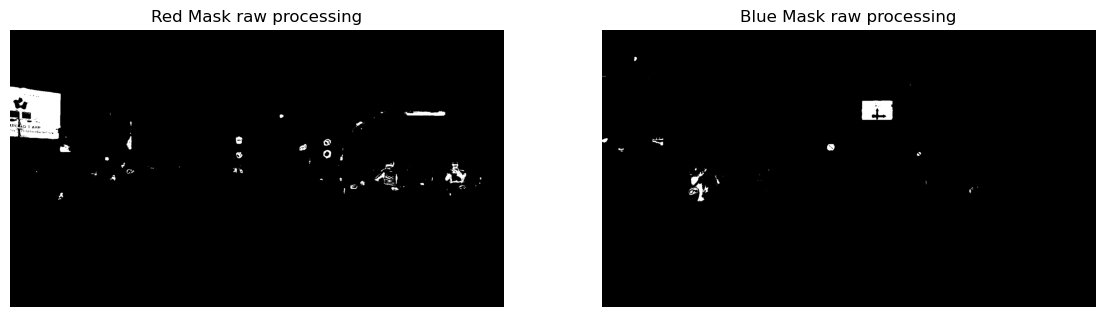

In [26]:
frame_processor = FrameProcessor()

preprocessed_frame = frame_processor.preprocess(frame, 3.0, (8, 8), 5, 0)  

mask_red_no_morphology, mask_blue_no_morphology = frame_processor.merge_masks(preprocessed_frame, morphology=False)


plt.figure(figsize=(14, 9))
plt.subplot(121), imshow(mask_red_no_morphology), plt.title("Red Mask raw processing")
plt.subplot(122), imshow(mask_blue_no_morphology), plt.title("Blue Mask raw processing")

#### 4.2 Improved Mask Extraction

These 2 masks above may still contain small noise, isolated pixels, or broken edges due to illumination changes, reflections, or background interference.

To improving them, the process combines opening, closing, and dilation operations to remove small noise regions, fill minor gaps, and slightly expand the detected mask regions.

(<Axes: title={'center': 'Blue Mask after morphology'}>,
 None,
 Text(0.5, 1.0, 'Blue Mask after morphology'))

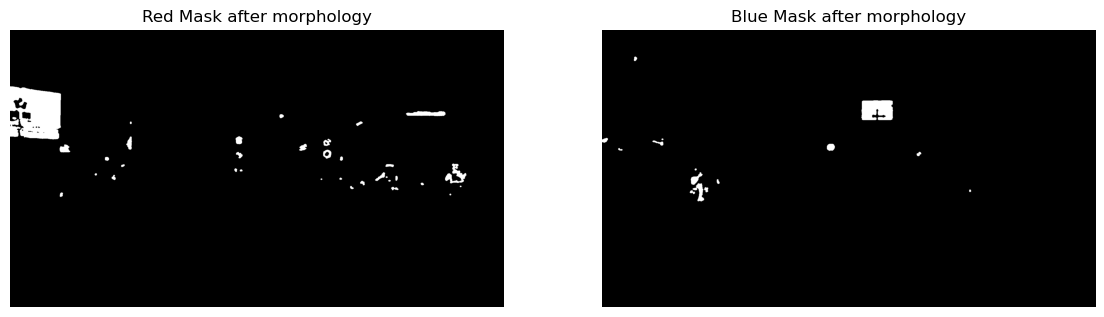

In [30]:
mask_red_apply_morphology, mask_blue_apply_morphology = frame_processor.merge_masks(preprocessed_frame, morphology=True)    

plt.figure(figsize=(14, 9))
plt.subplot(121), imshow(mask_red_apply_morphology), plt.title("Red Mask after morphology")
plt.subplot(122), imshow(mask_blue_apply_morphology), plt.title("Blue Mask after morphology")

### **5. Contour Detection and Shape Approximation**

#### 5.1 Contour Extraction

The process begins by applying cv.findContours() to both red and blue masks.

(<Axes: title={'center': 'Contours on Original Frame'}>,
 None,
 Text(0.5, 1.0, 'Contours on Original Frame'))

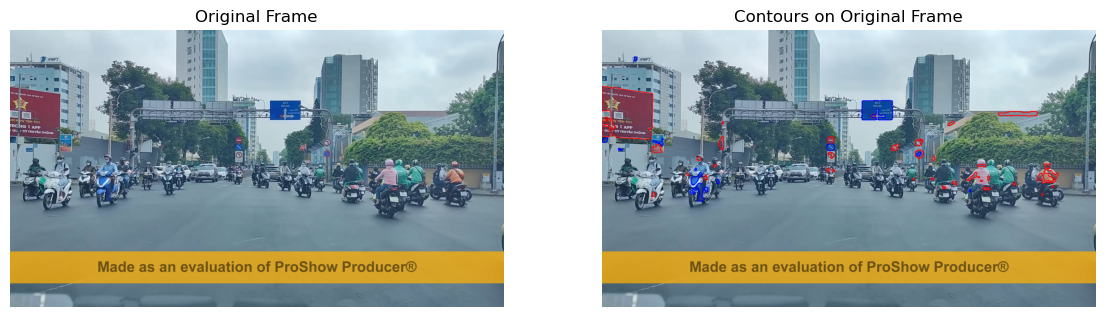

In [33]:
frame_temp = frame.copy()
contours_red, _ = cv.findContours(mask_red_apply_morphology, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_blue, _ = cv.findContours(mask_blue_apply_morphology, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
frame_temp = frame.copy()
cv.drawContours(frame_temp, contours_red, -1, (0, 0, 255), 2)
cv.drawContours(frame_temp, contours_blue, -1, (255, 0, 0), 2)

plt.figure(figsize=(14, 9))
plt.subplot(121), imshow(frame), plt.title("Original Frame")
plt.subplot(122), imshow(frame_temp), plt.title("Contours on Original Frame")

#### 5.2. Apply Shape Filtering and Approximation, Circularity Analysis

For each detected contour:

- The area of the contour is calculated, and regions smaller than the defined min_area threshold are ignored to eliminate noise.

- The perimeter is measured using cv.arcLength(), and the contour is simplified using cv.approxPolyDP() to approximate its geometric shape.

If the approximated contour consists of three vertices, it is tested for equilateral properties by comparing the side lengths.

For other contours, the algorithm checks for circular shapes:

- A minimum enclosing circle is computed using cv.minEnclosingCircle().

- The circularity ratio is obtained by comparing the contour area to the theoretical circle area.

If the circularity exceeds 0.67, the region is considered circular, and a bounding box is drawn to mark the detected sign.

(<Axes: title={'center': 'Detected Shapes on Original Frame'}>,
 None,
 Text(0.5, 1.0, 'Detected Shapes on Original Frame'))

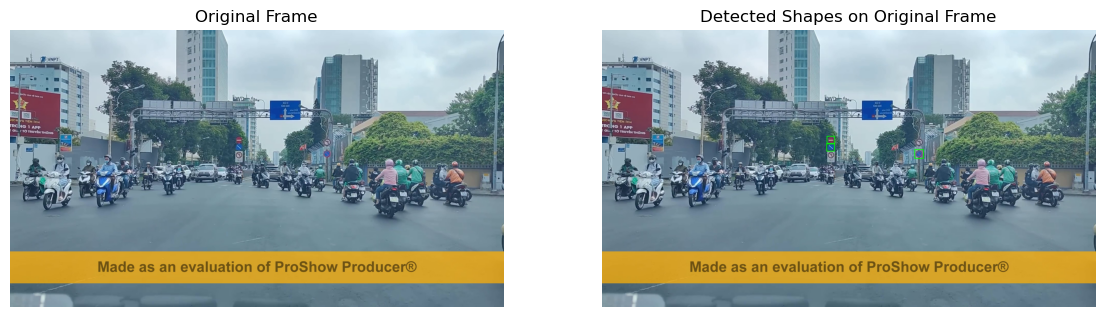

In [34]:
frame_temp = frame.copy()
contour_result = frame_processor.contour_process(frame_temp, mask_red_apply_morphology, mask_blue_apply_morphology, epsilon=0.03, min_area=600)

plt.figure(figsize=(14, 9))
plt.subplot(121), imshow(frame), plt.title("Original Frame")
plt.subplot(122), imshow(contour_result), plt.title("Detected Shapes on Original Frame")

### **6. Full pipeline for task 1**

Draw rectangles surrounding each Traffic sign in all frames of the input video automatically, and 
save the outputs into a new video file.
- Input: task1.mp4
- Output: another version of the input video “task1.mp4” with rectangles surrounding each 
traffic sign.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os

INPUT_VIDEO = "input.mp4"
OUTPUT_VIDEO = "ouput.mp4"

cap = cv.VideoCapture(INPUT_VIDEO)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {INPUT_VIDEO}")

frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv.CAP_PROP_FPS) or 25.0
print(f"[INFO] fps={fps}, size=({frame_width},{frame_height})")

fourcc = cv.VideoWriter_fourcc(*'mp4v')  # dùng mp4v để tránh cảnh báo XVID->mp4
out = cv.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (frame_width, frame_height))
if not out.isOpened():
    raise RuntimeError("Cannot open VideoWriter. Kiểm tra codec/đường dẫn đầu ra.")

frame_idx = 0

frame_processor = FrameProcessor()
while True:
    ret, frame = cap.read()
    if not ret:
        break

    img = frame.copy()

    img_processed = frame_processor.pipeline_full_process(img)
    out.write(img_processed)

    frame_idx += 1
    if frame_idx % 50 == 0:
        print(f"[INFO] processed {frame_idx} frames...")

# Cleanup
cap.release()
out.release()
cv.destroyAllWindows()
print("[INFO] Done. Output saved to:", OUTPUT_VIDEO)


[INFO] fps=29.97002997002997, size=(1920,1080)
[INFO] processed 50 frames...
[INFO] processed 100 frames...
[INFO] processed 150 frames...
[INFO] processed 200 frames...
[INFO] processed 250 frames...
[INFO] processed 300 frames...
[INFO] processed 350 frames...
[INFO] processed 400 frames...
[INFO] processed 450 frames...
[INFO] processed 500 frames...
[INFO] processed 550 frames...
[INFO] processed 600 frames...
[INFO] processed 650 frames...
[INFO] processed 700 frames...
[INFO] processed 750 frames...
[INFO] processed 800 frames...
[INFO] processed 850 frames...
[INFO] processed 900 frames...
[INFO] processed 950 frames...
[INFO] processed 1000 frames...
[INFO] processed 1050 frames...
[INFO] processed 1100 frames...
[INFO] processed 1150 frames...
[INFO] processed 1200 frames...
[INFO] processed 1250 frames...
[INFO] processed 1300 frames...
[INFO] processed 1350 frames...
[INFO] processed 1400 frames...
[INFO] processed 1450 frames...
[INFO] processed 1500 frames...
[INFO] proces